In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-03-23 18:18:44.371960: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-03-23 18:18:44.372014: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
cosmology = fiducial.AbacusSummitBase()
z = 1.175

# Mocks
nmocks = 25

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

# Legendre multipoles
ells = [0, 2, 4]

## Catalog

In [5]:
abacus_mock = catalog_data.Data.load('/feynman/scratch/dphp/mp270220/abacus/AbacusSummit_2Gpc_z{:.3f}_ph000.npy'.format(z))

## Gaussian model

In [6]:
#model_linear = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.012, damping=False, non_linear=False)
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.012, damping=False, non_linear=True)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


In [7]:
bg = cosmology.get_background(engine='class')
f = bg.growth_rate(z)
bias = 1.
beta = f / bias
kaiser_boost = np.array([1 + 2 * beta /3 + beta**2 /5., 4. * beta /3 + 4. * beta**2 /7., 8. * beta**2 / 35])

## Density field

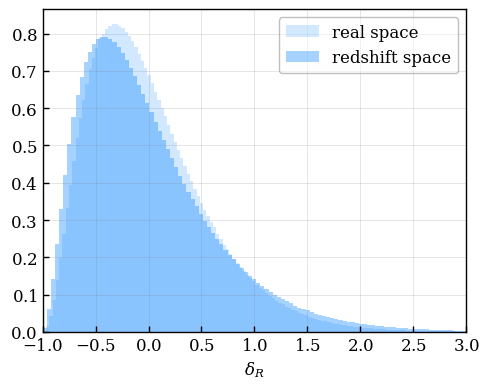

In [14]:
mock_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_ph000_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
mock_delta_R_RSD = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_ph000_cellsize{:d}_resampler{}_delta_R_RSD.npy'.format(z, cellsize, resampler))

delta_R_pdf = plt.hist(mock_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'real space')
delta_R_pdf_RSD = plt.hist(mock_delta_R_RSD, bins=200, density=True, alpha=0.4, color='C0', label=r'redshift space')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0004536613381187197
        x: [ 1.130e+00  6.609e-01  9.440e-01  3.878e-01  5.876e-02]
      nit: 31
      jac: [-6.982e-08 -1.706e-08 -4.333e-09  8.011e-09  4.984e-08]
 hess_inv: [[ 3.383e-01 -1.208e+00 ... -2.110e+00  2.432e-01]
            [-1.208e+00  5.266e+00 ...  9.125e+00 -1.008e+00]
            ...
            [-2.110e+00  9.125e+00 ...  1.648e+01 -1.819e+00]
            [ 2.432e-01 -1.008e+00 ... -1.819e+00  2.075e-01]]
     nfev: 228
     njev: 38
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0004631344953706421
        x: [ 1.178e+00  7.665e-01  9.518e-01  3.567e-01  3.848e-02]
      nit: 46
      jac: [-3.972e-06  2.525e-06  5.676e-07 -1.790e-06 -7.878e-06]
 hess_inv: [[ 4.323e-01  1.404e+00 ...  2.154e+00 -2.943e-01]
            [ 1.404e+00  5.715e+00 ...  8.779e+00 -1.248e+00]
            ...
            [ 2.154e+00  8.779e+00 ...  1.42

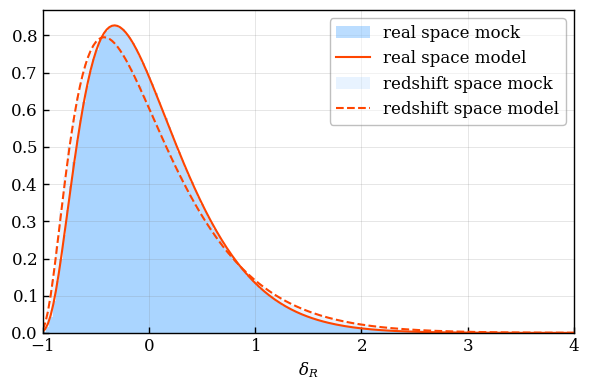

In [17]:
def biased_lognormal_model(delta, sigma, delta0, b1, b2, b3):
    delta2 = delta0**2*(np.exp(sigma**2)-1)
    delta3 = 3/delta0**2*delta2 + 1/delta0**3*delta2**(3./2)
    delta_bias = b1*delta + b2/2.*(delta**2 - delta2) + b3*(delta**3 - delta3)
    pdf_model = scipy.stats.lognorm.pdf(delta_bias, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

def compute_bestfit_delta0_sigma(delta_R_pdf):
    x = (delta_R_pdf[1][1:]+delta_R_pdf[1][:-1])/2.
    fx = delta_R_pdf[0]

    def to_min(params):
        delta0 = params[0]
        sigma = params[1]
        b1 = params[2]
        b2 = params[3]
        b3 = params[4]
        y = biased_lognormal_model(x, sigma, delta0, b1, b2, b3)
        return np.sum((fx-y)**2)

    res = minimize(to_min, x0=np.array([1., model.sigma_RR[0], 1., 0., 0.]))
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    b1 = res.x[2]
    b2 = res.x[3]
    b3 = res.x[4]
    return delta0, sigma, b1, b2, b3

delta0, sigma, b1, b2, b3 = compute_bestfit_delta0_sigma(delta_R_pdf)  
delta0_RSD, sigma_RSD, b1_RSD, b2_RSD, b3_RSD = compute_bestfit_delta0_sigma(delta_R_pdf_RSD)    

plt.rcParams["figure.figsize"] = (6, 4)
delta = np.linspace(-1, 4, 200)

plt.hist(mock_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'real space mock')
plt.plot(delta, biased_lognormal_model(delta, sigma, delta0, b1, b2, b3), color='C1', ls='-', label=r'real space model')
plt.hist(mock_delta_R_RSD, bins=200, density=True, alpha=0.1, color='C0', label=r'redshift space mock')
plt.plot(delta, biased_lognormal_model(delta, sigma_RSD, delta0_RSD, b1_RSD, b2_RSD, b3_RSD), color='C1', ls='--', label=r'redshift space model')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
#plt.yscale('log')
#plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()